# Projet 4 Prédiction de retard de vols : Analyse Exploratoire

### Initialisation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os as os
import seaborn as sns
from random import sample
from scipy import stats
import scipy.stats as st
from sklearn import linear_model, metrics, svm
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

%matplotlib inline

plt.style.use('seaborn-notebook')
sns.set_style('ticks')
sns.set(rc={'figure.figsize': (12, 8)})
sns.set(rc={'font.size': 15})

os.getcwd()
os.chdir("C:/Users/flemeill/Documents/01 - Projets OC/04 - Projet 4 - Retards/Main project")

In [2]:
def distri_plot(Var, X):
    """Fonction permettant d'afficher la distribution statistique d'une variable (courbe + histogramme)"""
    sns.distplot(Var)
    plt.xlabel(X, fontsize=18)
    plt.ylabel("Distribution", fontsize=18)
    plt.title("Distribution de " + X, fontsize=24)
    print("La médiane de ", X, "est de ", Var.median())
    print("La moyenne de ", X, "est de ", Var.mean())


def boxplot1d(X, title):
    """Fonction permettant d'afficher la distribution statistique d'une variable en boite à moustache"""
    sns.boxplot(X)
    plt.title(title, fontsize=24)
    print(X.describe())


def evaluate_completnes_df(data):
    "Création de la fonction pour évaluer la complétion d'un jeu de données"
    IsNull = pd.isnull(data)
    EmptynessRatio = IsNull.sum().sum()/data.size
    return (print("La matrice est complète à :",
                  np.around((1-EmptynessRatio), decimals=3)*100, "%"))

# Import des données

In [3]:
data01 = pd.read_csv('2016_01.csv', low_memory=False, error_bad_lines=False)
data02 = pd.read_csv('2016_02.csv', low_memory=False, error_bad_lines=False)
data03 = pd.read_csv('2016_03.csv', low_memory=False, error_bad_lines=False)
data04 = pd.read_csv('2016_04.csv', low_memory=False, error_bad_lines=False)
data05 = pd.read_csv('2016_05.csv', low_memory=False, error_bad_lines=False)
data06 = pd.read_csv('2016_06.csv', low_memory=False, error_bad_lines=False)
data07 = pd.read_csv('2016_07.csv', low_memory=False, error_bad_lines=False)
data08 = pd.read_csv('2016_08.csv', low_memory=False, error_bad_lines=False)
data09 = pd.read_csv('2016_09.csv', low_memory=False, error_bad_lines=False)
data10 = pd.read_csv('2016_10.csv', low_memory=False, error_bad_lines=False)
data11 = pd.read_csv('2016_11.csv', low_memory=False, error_bad_lines=False)
data12 = pd.read_csv('2016_12.csv', low_memory=False, error_bad_lines=False)

b'Skipping line 121012: expected 65 fields, saw 75\nSkipping line 386249: expected 65 fields, saw 83\nSkipping line 388291: expected 65 fields, saw 78\nSkipping line 389371: expected 65 fields, saw 72\nSkipping line 389548: expected 65 fields, saw 81\nSkipping line 453858: expected 65 fields, saw 97\n'


In [4]:
data_m = data01.merge(data02, how='outer')
data_m = data_m.merge(data03, how='outer')
data_m = data_m.merge(data04, how='outer')
data_m = data_m.merge(data05, how='outer')
data_m = data_m.merge(data06, how='outer')
data_m = data_m.merge(data07, how='outer')
data_m = data_m.merge(data08, how='outer')
data_m = data_m.merge(data09, how='outer')
data_m = data_m.merge(data10, how='outer')
data_m = data_m.merge(data11, how='outer')
data_m = data_m.merge(data12, how='outer')

Le jeu de données est très lourd, on ne va considérer, dans un premier temps, que 8% des données, cela représente tout de même
450 878 lignes

In [111]:
N = int(round(0.08 * data_m.shape[0]))
print(N)
randomIndex = np.array(sample(range(len(data_m)), N))
data_or = data_m.loc[randomIndex]

450878


In [112]:
data = data_or

In [113]:
data_or.head()

YEAR QUARTER  MONTH DAY_OF_MONTH DAY_OF_WEEK     FL_DATE  \
2257351  2016       2      5           23           1  2016-05-23   
5530416  2016       4     12           19           1  2016-12-19   
693573   2016       1      2           18           4  2016-02-18   
4108819  2016       3      9           21           3  2016-09-21   
3667434  2016       3      8            4           4  2016-08-04   

        UNIQUE_CARRIER  AIRLINE_ID CARRIER TAIL_NUM     ...      \
2257351             AA       19805      AA   N510UW     ...       
5530416             VX       21171      VX   N638VA     ...       
693573              DL       19790      DL   N913DE     ...       
4108819             WN       19393      WN   N8609A     ...       
3667434             UA       19977      UA   N444UA     ...       

        DISTANCE_GROUP CARRIER_DELAY  WEATHER_DELAY NAS_DELAY SECURITY_DELAY  \
2257351            4.0           NaN            NaN       NaN            NaN   
5530416           11.0           NaN            NaN       NaN            NaN   
693573             2.0           NaN            NaN       NaN            NaN   
4108819            2.0           NaN            NaN       NaN            NaN   
3667434            2.0           NaN            NaN       NaN            NaN   

        LATE_AIRCRAFT_DELAY FIRST_DEP_TIME  TOTAL_ADD_GTIME LONGEST_ADD_GTIME  \
2257351                 NaN            NaN              NaN               NaN   
5530416                 NaN            NaN              NaN               NaN   
693573                  NaN            NaN              NaN               NaN   
4108819                 NaN            NaN              NaN               NaN   
3667434                 NaN            NaN              NaN               NaN   

        Unnamed: 64  
2257351         NaN  
5530416         NaN  
693573          NaN  
4108819         NaN  
3667434         NaN  

[5 rows x 65 columns]

### Import des tables de lecture 

Dans notre base de données les aéroports et les compagnies aériennes sont représentés par des codes ou des ID.
Les correspondances avec les 'vrais' noms des aéroports ou des compagnies sont fournies dans des tables, que nous importons ici.

In [114]:
table_airline = pd.read_csv('L_AIRLINE_ID.csv_')
table_airport = pd.read_csv('L_AIRPORT_ID.csv_')

In [115]:
print(table_airline.head(10))
print(table_airline.shape)

    Code                      Description
0  19031   Mackey International Inc.: MAC
1  19032  Munz Northern Airlines Inc.: XY
2  19033       Cochise Airlines Inc.: COC
3  19034   Golden Gate Airlines Inc.: GSA
4  19035               Aeromech Inc.: RZZ
5  19036    Golden West Airlines Co.: GLW
6  19037   Puerto Rico Intl Airlines: PRN
7  19038            Air America Inc.: STZ
8  19039       Swift Aire Lines Inc.: SWT
9  19040   American Central Airlines: TSF
(1642, 2)


Création du dictionnaire pour les compagnies aériennes

In [116]:
dict_airline = dict(zip(table_airline.Code, table_airline.Description))

In [117]:
print(table_airport.shape)
table_airport.head(10)

(6461, 2)


Code                                     Description
0  10001          Afognak Lake, AK: Afognak Lake Airport
1  10003   Granite Mountain, AK: Bear Creek Mining Strip
2  10004                        Lik, AK: Lik Mining Camp
3  10005          Little Squaw, AK: Little Squaw Airport
4  10006                      Kizhuyak, AK: Kizhuyak Bay
5  10007              Klawock, AK: Klawock Seaplane Base
6  10008  Elizabeth Island, AK: Elizabeth Island Airport
7  10009                      Homer, AK: Augustin Island
8  10010                     Hudson, NY: Columbia County
9  10011            Peach Springs, AZ: Grand Canyon West

Création du dictionnaire pour les aéroports

In [118]:
dict_airport = dict(zip(table_airport.Code, table_airport.Description))

## Sélection des variables

La forme de notre data set avec 8% des données totales

In [119]:
print(data.shape)

(450878, 65)


In [120]:
evaluate_completnes_df(data)

La matrice est complète à : 85.7 %


La matrice est assez complète, il manque moins de 15% des données. 
Regardons nos colonnes pour identifier ce qu'elles representent

In [121]:
print(data.columns)

Index(['YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE',
       'UNIQUE_CARRIER', 'AIRLINE_ID', 'CARRIER', 'TAIL_NUM', 'FL_NUM',
       'ORIGIN_AIRPORT_ID', 'ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN_CITY_MARKET_ID',
       'ORIGIN', 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR', 'ORIGIN_STATE_FIPS',
       'ORIGIN_STATE_NM', 'ORIGIN_WAC', 'DEST_AIRPORT_ID',
       'DEST_AIRPORT_SEQ_ID', 'DEST_CITY_MARKET_ID', 'DEST', 'DEST_CITY_NAME',
       'DEST_STATE_ABR', 'DEST_STATE_FIPS', 'DEST_STATE_NM', 'DEST_WAC',
       'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'DEP_DELAY_NEW', 'DEP_DEL15',
       'DEP_DELAY_GROUP', 'DEP_TIME_BLK', 'TAXI_OUT', 'WHEELS_OFF',
       'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY',
       'ARR_DELAY_NEW', 'ARR_DEL15', 'ARR_DELAY_GROUP', 'ARR_TIME_BLK',
       'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'CRS_ELAPSED_TIME',
       'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'FLIGHTS', 'DISTANCE',
       'DISTANCE_GROUP', 'CARRIER_DELAY', 'WEATHER_DELAY

Nous identifions dans un premier temps les colonnes jugées d'intêret pour notre étude.     
Ce choix est subjectif et se base sur notre analyse de la base de donnée et du cadre de l'étude


In [122]:
ToKeep= ['QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE', 'UNIQUE_CARRIER', 'AIRLINE_ID', 
        'ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', 'CRS_DEP_TIME', 'DEP_DELAY','ARR_DELAY', 'CRS_ARR_TIME', 'CRS_ELAPSED_TIME',
        'ACTUAL_ELAPSED_TIME', 'DISTANCE']
data2 = data[ToKeep]

In [123]:
evaluate_completnes_df(data2)

La matrice est complète à : 99.8 %


Les variables d'interet ont un meilleur taux de complétion que le data set entier

Etudions rapidement les variables retards (la variable retard est la variable cible dans cette étude)

In [124]:
data2['ARR_DELAY'].describe()

count    444531.000000
mean          3.450828
std          41.850212
min         -92.000000
25%         -14.000000
50%          -6.000000
75%           6.000000
max        1971.000000
Name: ARR_DELAY, dtype: float64

In [125]:
data2['ARR_DELAY'].head(10)

2257351   -13.0
5530416    13.0
693573    -22.0
4108819   -10.0
3667434    -9.0
3088719   -14.0
124746    -28.0
5429974     9.0
4956944   -18.0
5068183   -25.0
Name: ARR_DELAY, dtype: float64

In [126]:
data2['DEP_DELAY'].describe()

count    445830.000000
mean          8.912716
std          39.769238
min         -60.000000
25%          -5.000000
50%          -2.000000
75%           6.000000
max        1964.000000
Name: DEP_DELAY, dtype: float64

In [127]:
data2['DEP_DELAY'].head(10)

2257351    -3.0
5530416     9.0
693573     -2.0
4108819    -3.0
3667434    -3.0
3088719    -1.0
124746     -3.0
5429974    14.0
4956944    -9.0
5068183     0.0
Name: DEP_DELAY, dtype: float64

On supprime les doublons si notre échantillon en contient

In [128]:
print(data2.shape)
data2 = data2.drop_duplicates()
print(data2.shape)

(450878, 16)
(450878, 16)


## Analyse complémentaire sur les colonnes

Regardons ou se situe les quelques valeurs manquantes de notre data set

In [129]:
data2.isnull().sum(axis=0)

QUARTER                   0
MONTH                     0
DAY_OF_MONTH              0
DAY_OF_WEEK               0
FL_DATE                   0
UNIQUE_CARRIER            0
AIRLINE_ID                0
ORIGIN_AIRPORT_ID         0
DEST_AIRPORT_ID           0
CRS_DEP_TIME              0
DEP_DELAY              5048
ARR_DELAY              6347
CRS_ARR_TIME              0
CRS_ELAPSED_TIME          1
ACTUAL_ELAPSED_TIME    6348
DISTANCE                  1
dtype: int64

ARR DELAY est la variable cible, celle que nous cherchons à prédire, nous supprimons donc les lignes où cette information 
est manquante sur notre jeu de données

In [130]:
data2 = data2.dropna(subset=['ARR_DELAY'])
print(data2.shape)
evaluate_completnes_df(data2)

(444531, 16)
La matrice est complète à : 100.0 %


Notre jeu de données est maintenant complet 

L'information Quarter est déjà contenu dans l'information du mois. On choisit de garder l'information 'Mois' qui est plus fine

In [131]:
data2 = data2.drop(['QUARTER'], axis=1)

Actual elapsed time est une variable renseignée après le vol de l'avion,
donc ne pourra pas être disponible en amont du vol, donc à ne pas considérer dans un cas de prédiction

In [132]:
data2 = data2.drop(['ACTUAL_ELAPSED_TIME'], axis=1)

UNIQUE_CARRIER et AIRLINE_ID sont redondants on peut donc n'en garder qu'un

In [133]:
data2 = data2.drop(['UNIQUE_CARRIER'], axis=1)

Après ce premier tri rapide, faisons un point sur les colonnes que nous considérons 

In [134]:
data2.columns

Index(['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE', 'AIRLINE_ID',
       'ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', 'CRS_DEP_TIME', 'DEP_DELAY',
       'ARR_DELAY', 'CRS_ARR_TIME', 'CRS_ELAPSED_TIME', 'DISTANCE'],
      dtype='object')

In [135]:
data2.head(10)

MONTH DAY_OF_MONTH DAY_OF_WEEK     FL_DATE  AIRLINE_ID  \
2257351      5           23           1  2016-05-23       19805   
5530416     12           19           1  2016-12-19       21171   
693573       2           18           4  2016-02-18       19790   
4108819      9           21           3  2016-09-21       19393   
3667434      8            4           4  2016-08-04       19977   
3088719      7           19           2  2016-07-19       19790   
124746       1           27           3  2016-01-27       19790   
5429974     12            9           5  2016-12-09       20304   
4956944     11            4           5  2016-11-04       20416   
5068183     11           19           6  2016-11-19       19805   

        ORIGIN_AIRPORT_ID DEST_AIRPORT_ID  CRS_DEP_TIME  DEP_DELAY  ARR_DELAY  \
2257351             11057           11298        2210.0       -3.0      -13.0   
5530416             12478           14771        1155.0        9.0       13.0   
693573              13244           10397        1601.0       -2.0      -22.0   
4108819             12889           13796        1755.0       -3.0      -10.0   
3667434             14771           12892         940.0       -3.0       -9.0   
3088719             14771           13487         800.0       -1.0      -14.0   
124746              13486           13487         540.0       -3.0      -28.0   
5429974             11292           11109        2000.0       14.0        9.0   
4956944             11697           10397         755.0       -9.0      -18.0   
5068183             12478           12892        1000.0        0.0      -25.0   

         CRS_ARR_TIME  CRS_ELAPSED_TIME  DISTANCE  
2257351        2357.0             167.0     936.0  
5530416        1510.0             375.0    2586.0  
693573         1830.0              89.0     332.0  
4108819        1920.0              85.0     407.0  
3667434        1114.0              94.0     337.0  
3088719        1335.0             215.0    1589.0  
124746          922.0             162.0    1013.0  
5429974        2047.0              47.0      73.0  
4956944         947.0             112.0     581.0  
5068183        1339.0             399.0    2475.0

Vérifions que les dates correspondent bien à 2016

In [136]:
print(data2.shape)
Date_début = '2015-12-31T00:00:00'
Date_fin = '2017-01-01T00:00:00'
data2['FL_DATE'] = pd.to_datetime(data2['FL_DATE'])
data2 = data2[data2.FL_DATE>Date_début]
data2 = data2[data2.FL_DATE<Date_fin]
print(data2.shape)

(444531, 13)
(444531, 13)


## Etude sur les villes et aéroports

In [137]:
data['ORIGIN_CITY_NAME'].value_counts()
data['ORIGIN_CITY_NAME'].nunique()
data.shape

(450878, 65)

In [138]:
data_cityname = data[['ORIGIN_CITY_NAME', 'DEST_CITY_NAME', 'DISTANCE']]
print(data_cityname.head(20))
data_cityname = data_cityname.drop_duplicates(['ORIGIN_CITY_NAME', 'DEST_CITY_NAME'])
print(data_cityname.shape)

            ORIGIN_CITY_NAME         DEST_CITY_NAME  DISTANCE
2257351        Charlotte, NC  Dallas/Fort Worth, TX     936.0
5530416         New York, NY      San Francisco, CA    2586.0
693573           Memphis, TN            Atlanta, GA     332.0
4108819        Las Vegas, NV            Oakland, CA     407.0
3667434    San Francisco, CA        Los Angeles, CA     337.0
3088719    San Francisco, CA        Minneapolis, MN    1589.0
124746          Missoula, MT        Minneapolis, MN    1013.0
5429974           Denver, CO   Colorado Springs, CO      73.0
4956944  Fort Lauderdale, FL            Atlanta, GA     581.0
5068183         New York, NY        Los Angeles, CA    2475.0
3267226          Seattle, WA         Washington, DC    2306.0
924880        Washington, DC        Minneapolis, MN     931.0
199388            Newark, NJ             Boston, MA     200.0
4480234            Tampa, FL         Birmingham, AL     459.0
2280244      Los Angeles, CA            Seattle, WA     954.0
351418  

Nous exportons cette base de données afin de pouvoir calculer la distance dans notre API à partir des villes renseignées par l'utilisateur.
Cela nous permet également d'avoir la liste des villes pouvant être choisies

In [139]:
import pickle 
with open('df_dist', 'wb') as fid:
    pickle.dump(data_cityname, fid,2)
    
    
data_cityname.to_csv(path_or_buf = 'C:/Users/flemeill/Documents/01 - Projets OC/04 - Projet 4 - Retards/Main project/df_dist.csv')
data_cityname.to_csv(path_or_buf = 'C:/Users/flemeill/Documents/01 - Projets OC/04 - Projet 4 - Retards/Flask/App_test/Models/df_dist.csv')

Il y a 304 villes différentes dans notre jeu de données

## Feature Engineering

Il peut être intéressant d'identifier les zones de 'vacances' ou de week-end prolongé aux USA. En effet à ces périodes 
le trafic aérien est plus chargé que d'ordinaire et cela peut engendrer des retards 

#### Dates des jours fériés aux USA en 2016

In [140]:
Holidays = ['2016-1-01', '2016-1-18', '2016-2-15', '2016-3-28', '2016-5-16', '2016-5-30', '2016-7-04',
            '2016-9-05', '2016-11-24', '2016-12-25']

In [141]:
Holidays = pd.to_datetime(Holidays)
print(Holidays)

DatetimeIndex(['2016-01-01', '2016-01-18', '2016-02-15', '2016-03-28',
               '2016-05-16', '2016-05-30', '2016-07-04', '2016-09-05',
               '2016-11-24', '2016-12-25'],
              dtype='datetime64[ns]', freq=None)


In [142]:
def days_to_hdays(date):
    """Calcul du nombre de jour séparant la date entrée et le jour férié le plus proche (pour 2016) """

    # Create a DATE object we can use to calculate the time difference
    currDate = pd.to_datetime(date)

    # Now find the minimum difference between the date and our holidays
    numDays = min(abs((currDate-Holidays).days))
    return(numDays)

Calcul de la table indiquant le nombre de jours entre le jour de l'année est le jour férié le plus proche

In [143]:
hdays = []
dates_year = data2.FL_DATE.unique()

for d in dates_year: 
    hdays.append(days_to_hdays(d))

table_hdays = pd.DataFrame(data=hdays, columns=['hdays'], dtype=int)
table_hdays['dates_year'] = pd.to_datetime(dates_year)
dict_hdays = dict(zip(table_hdays.dates_year, table_hdays.hdays))

Création de la variable 'hdays' indiquant la distance du jour du vol au jour férié le plus proche (distance en jours)

In [144]:
data2['hdays'] = data2['FL_DATE'].map(dict_hdays)

In [145]:
data2.dtypes

MONTH                         int64
DAY_OF_MONTH                 object
DAY_OF_WEEK                  object
FL_DATE              datetime64[ns]
AIRLINE_ID                    int64
ORIGIN_AIRPORT_ID            object
DEST_AIRPORT_ID              object
CRS_DEP_TIME                float64
DEP_DELAY                   float64
ARR_DELAY                   float64
CRS_ARR_TIME                float64
CRS_ELAPSED_TIME            float64
DISTANCE                    float64
hdays                         int64
dtype: object

Les colonnes de type 'object' ci-dessus sont de ce type car elles contiennent des valeurs stockées sous le format str et d'autres sont le format int
Comme nous allons considérer ces variables comme catégorielles nous pouvons les convertir en string

In [146]:
data2['DAY_OF_WEEK'] = data2['DAY_OF_WEEK'].apply(lambda x: pd.to_numeric(x))
data2['DAY_OF_MONTH'] = data2['DAY_OF_MONTH'].apply(lambda x: pd.to_numeric(x))
data2['MONTH'] = data2['MONTH'].apply(lambda x: pd.to_numeric(x))
print(data2['DAY_OF_WEEK'].value_counts())

5.0    66493
4.0    65793
3.0    65640
1.0    65387
2.0    65120
7.0    61962
6.0    54136
Name: DAY_OF_WEEK, dtype: int64


In [147]:
data2['AIRLINE_ID'] = data2['AIRLINE_ID'].apply(lambda x: pd.to_numeric(x))

In [148]:
data2.dtypes

MONTH                         int64
DAY_OF_MONTH                float64
DAY_OF_WEEK                 float64
FL_DATE              datetime64[ns]
AIRLINE_ID                    int64
ORIGIN_AIRPORT_ID            object
DEST_AIRPORT_ID              object
CRS_DEP_TIME                float64
DEP_DELAY                   float64
ARR_DELAY                   float64
CRS_ARR_TIME                float64
CRS_ELAPSED_TIME            float64
DISTANCE                    float64
hdays                         int64
dtype: object

In [149]:
print(data2.head(10))
data2.hdays.describe()

         MONTH  DAY_OF_MONTH  DAY_OF_WEEK    FL_DATE  AIRLINE_ID  \
2257351      5          23.0          1.0 2016-05-23       19805   
5530416     12          19.0          1.0 2016-12-19       21171   
693573       2          18.0          4.0 2016-02-18       19790   
4108819      9          21.0          3.0 2016-09-21       19393   
3667434      8           4.0          4.0 2016-08-04       19977   
3088719      7          19.0          2.0 2016-07-19       19790   
124746       1          27.0          3.0 2016-01-27       19790   
5429974     12           9.0          5.0 2016-12-09       20304   
4956944     11           4.0          5.0 2016-11-04       20416   
5068183     11          19.0          6.0 2016-11-19       19805   

        ORIGIN_AIRPORT_ID DEST_AIRPORT_ID  CRS_DEP_TIME  DEP_DELAY  ARR_DELAY  \
2257351             11057           11298        2210.0       -3.0      -13.0   
5530416             12478           14771        1155.0        9.0       13.0   
693573  

count    444531.000000
mean         12.339819
std           9.423075
min           0.000000
25%           5.000000
50%          10.000000
75%          18.000000
max          40.000000
Name: hdays, dtype: float64

On considère les heures de départ et d'arrivée et non plus heure et minutes concaténées

In [150]:
data2['DEP_HOUR'] = round(data2['CRS_DEP_TIME'] / 100, 0)
data2['ARR_HOUR'] = round(data2['CRS_ARR_TIME'] / 100, 0)

Nous pouvons donc supprimer les variables CRS_DEP_TIME et CRS_ARR_TIME.     
Nous supprimons aussi la variable FL_DATE puisque l'information contenue dans celle-ci est retrouvée avec les variables 'MONTH'
et 'DAY_OF_MONTH'

Enfin, la variable 'DEP_DELAY' est beaucoup trop liée à la variable du retard à l'arrivée. La considérer impliquerait de réaliser un data leakage sur notre modèle

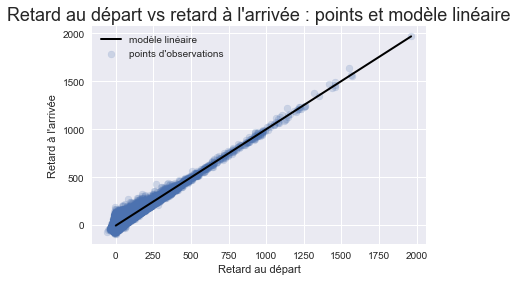

In [151]:
DEP = data2.DEP_DELAY
ARR = data2.ARR_DELAY

Reg_mod = linear_model.LinearRegression()
Reg_mod.fit(DEP[:,np.newaxis], ARR)

ax = plt.axes()
plt.scatter(x = data2.DEP_DELAY , y = data2.ARR_DELAY ,alpha=0.2 , label ="points d'observations")

x_test = np.linspace(0, np.max(DEP), 100)
plt.plot(x_test, Reg_mod.predict(x_test[:,np.newaxis]), color='black', linewidth=2, label = 'modèle linéaire', alpha=1)

plt.title("Retard au départ vs retard à l'arrivée : points et modèle linéaire", fontsize = 18)
plt.legend(loc='upper left')

ax = ax.set(xlabel='Retard au départ', ylabel="Retard à l'arrivée")

plt.show()

In [152]:
st.pearsonr(data2.DEP_HOUR, data2.ARR_HOUR)

(0.6740770940333551, 0.0)

In [153]:
ToDrop = ['CRS_DEP_TIME', 'CRS_ARR_TIME', 'FL_DATE', 'DEP_DELAY']
data2 = data2.drop(ToDrop, axis=1)

De manière générale, par rapport à notre étude où le but final est de réaliser des prédictions, nous souhaitons considérer en variables explicatives
uniquement des variables pour lesquelles l'information est disponible avant le vol 

In [154]:
data2.head()

MONTH  DAY_OF_MONTH  DAY_OF_WEEK  AIRLINE_ID ORIGIN_AIRPORT_ID  \
2257351      5          23.0          1.0       19805             11057   
5530416     12          19.0          1.0       21171             12478   
693573       2          18.0          4.0       19790             13244   
4108819      9          21.0          3.0       19393             12889   
3667434      8           4.0          4.0       19977             14771   

        DEST_AIRPORT_ID  ARR_DELAY  CRS_ELAPSED_TIME  DISTANCE  hdays  \
2257351           11298      -13.0             167.0     936.0      7   
5530416           14771       13.0             375.0    2586.0      6   
693573            10397      -22.0              89.0     332.0      3   
4108819           13796      -10.0              85.0     407.0     16   
3667434           12892       -9.0              94.0     337.0     31   

         DEP_HOUR  ARR_HOUR  
2257351      22.0      24.0  
5530416      12.0      15.0  
693573       16.0      18.0  
4108819      18.0      19.0  
3667434       9.0      11.0

Comme les variables ci-dessous sont catégorielles, nous pouvons remplcer les ID par les valeurs textes.
Pour cela nous utilisons les tables fournies et importées en début de notebook (qui ont été transformées en dictionnaire)

In [155]:
data2['AIRLINE_ID'] = data2['AIRLINE_ID'].map(dict_airline)
data2['ORIGIN_AIRPORT_ID'] = data2['ORIGIN_AIRPORT_ID'].map(dict_airport)
data2['DEST_AIRPORT_ID'] = data2['DEST_AIRPORT_ID'].map(dict_airport)

In [156]:
data2['AIRLINE_ID'] = data2['AIRLINE_ID'].apply(lambda x: str(x))
data2['AIRLINE_ID'] = data2['AIRLINE_ID'].astype(str)

In [157]:
data2['AIRLINE_ID'].unique()

array(['American Airlines Inc.: AA', 'Virgin America: VX',
       'Delta Air Lines Inc.: DL', 'Southwest Airlines Co.: WN',
       'United Air Lines Inc.: UA', 'SkyWest Airlines Inc.: OO',
       'Spirit Air Lines: NK', 'Alaska Airlines Inc.: AS',
       'Hawaiian Airlines Inc.: HA', 'Frontier Airlines Inc.: F9',
       'JetBlue Airways: B6', 'ExpressJet Airlines Inc.: EV'],
      dtype=object)

In [159]:
print(data2.isnull().sum())
data2 = data2.interpolate()
print(data2.isnull().sum())

MONTH                    0
DAY_OF_MONTH             0
DAY_OF_WEEK              0
AIRLINE_ID               0
ORIGIN_AIRPORT_ID    37810
DEST_AIRPORT_ID      37810
ARR_DELAY                0
CRS_ELAPSED_TIME         1
DISTANCE                 1
hdays                    0
DEP_HOUR                 0
ARR_HOUR                 0
dtype: int64
MONTH                    0
DAY_OF_MONTH             0
DAY_OF_WEEK              0
AIRLINE_ID               0
ORIGIN_AIRPORT_ID    37810
DEST_AIRPORT_ID      37810
ARR_DELAY                0
CRS_ELAPSED_TIME         0
DISTANCE                 0
hdays                    0
DEP_HOUR                 0
ARR_HOUR                 0
dtype: int64


A ce stade, nous avons donc 1 variable cible et 11 variables explicatives 

## Analyse univariée et multivariée

Analyses statistiques sur les principales variables d'intéret du jeu de données

In [160]:
data2.describe()

MONTH   DAY_OF_MONTH    DAY_OF_WEEK      ARR_DELAY  \
count  444531.000000  444531.000000  444531.000000  444531.000000   
mean        6.512365      15.835258       3.929386       3.450828   
std         3.410180       8.800447       1.985869      41.850212   
min         1.000000       1.000000       1.000000     -92.000000   
25%         3.000000       8.000000       2.000000     -14.000000   
50%         7.000000      16.000000       4.000000      -6.000000   
75%         9.000000      23.000000       6.000000       6.000000   
max        12.000000      31.000000       7.000000    1971.000000   

       CRS_ELAPSED_TIME       DISTANCE          hdays       DEP_HOUR  \
count     444531.000000  444531.000000  444531.000000  444531.000000   
mean         145.376392     849.781311      12.339819      13.162148   
std           76.498962     620.044493       9.423075       4.909213   
min           18.000000      31.000000       0.000000       0.000000   
25%           88.000000     391.000000       5.000000       9.000000   
50%          126.000000     678.000000      10.000000      13.000000   
75%          178.000000    1091.000000      18.000000      17.000000   
max          705.000000    4983.000000      40.000000      24.000000   

            ARR_HOUR  
count  444531.000000  
mean       14.769854  
std         5.166252  
min         0.000000  
25%        11.000000  
50%        15.000000  
75%        19.000000  
max        24.000000

La médiane de  retard est de  -6.0
La moyenne de  retard est de  3.450827951256493


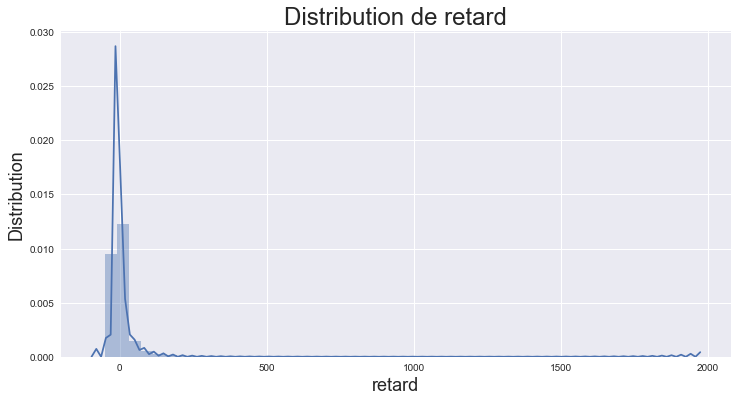

In [161]:
fig = plt.figure(figsize=(12, 6))
distri_plot(data2['ARR_DELAY'], 'retard')

La médiane de  retard inférieur à 100 minutes est de  -6.0
La moyenne de  retard inférieur à 100 minutes est de  -1.662515448456543


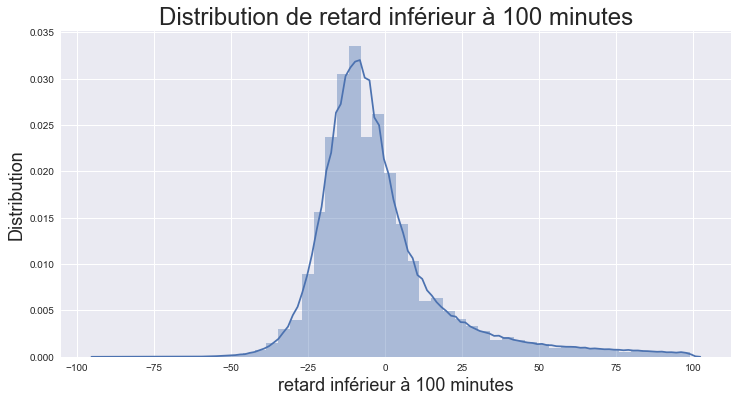

In [162]:
fig = plt.figure(figsize=(12, 6))
distri_plot(data2[data2['ARR_DELAY']<100]['ARR_DELAY'], 'retard inférieur à 100 minutes')

count    444531.000000
mean          3.450828
std          41.850212
min         -92.000000
25%         -14.000000
50%          -6.000000
75%           6.000000
max        1971.000000
Name: ARR_DELAY, dtype: float64


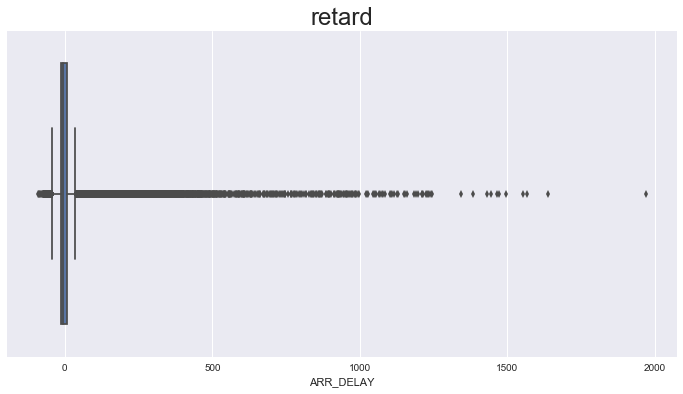

In [163]:
fig = plt.figure(figsize=(12, 6))
boxplot1d(data2['ARR_DELAY'], 'retard')

In [164]:
np.percentile(data2['ARR_DELAY'],97.5)

107.0

count    432082.000000
mean         -1.662515
std          21.530121
min         -92.000000
25%         -14.000000
50%          -6.000000
75%           5.000000
max          99.000000
Name: ARR_DELAY, dtype: float64


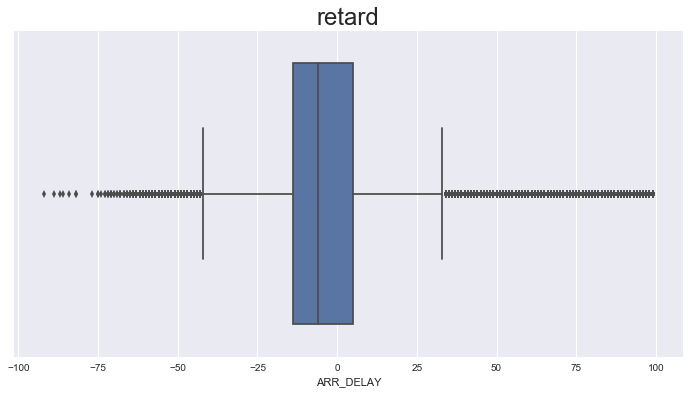

In [165]:
fig = plt.figure(figsize=(12, 6))
boxplot1d(data2[data2['ARR_DELAY']<100]['ARR_DELAY'], 'retard')

In [166]:
data2[data2['ARR_DELAY'] < 0].shape

(284086, 12)

La médiane de  DISTANCE est de  678.0
La moyenne de  DISTANCE est de  849.7813110896653


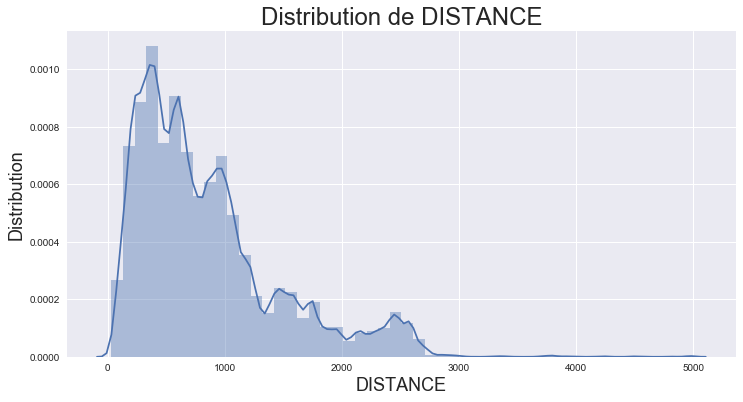

In [167]:
fig = plt.figure(figsize=(12, 6))
distri_plot(data2['DISTANCE'], 'DISTANCE')

count    444531.000000
mean        849.781311
std         620.044493
min          31.000000
25%         391.000000
50%         678.000000
75%        1091.000000
max        4983.000000
Name: DISTANCE, dtype: float64


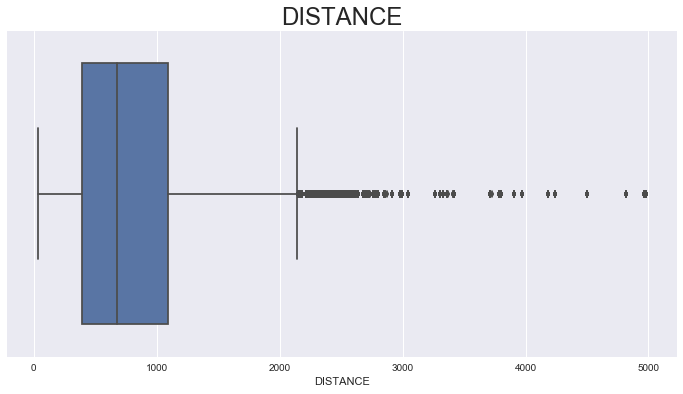

In [168]:
fig = plt.figure(figsize=(12, 6))
boxplot1d(data2['DISTANCE'], 'DISTANCE')

Index(['Southwest Airlines Co.: WN', 'Delta Air Lines Inc.: DL',
       'American Airlines Inc.: AA', 'SkyWest Airlines Inc.: OO',
       'United Air Lines Inc.: UA', 'ExpressJet Airlines Inc.: EV',
       'JetBlue Airways: B6', 'Alaska Airlines Inc.: AS',
       'Spirit Air Lines: NK', 'Frontier Airlines Inc.: F9',
       'Hawaiian Airlines Inc.: HA', 'Virgin America: VX'],
      dtype='object')


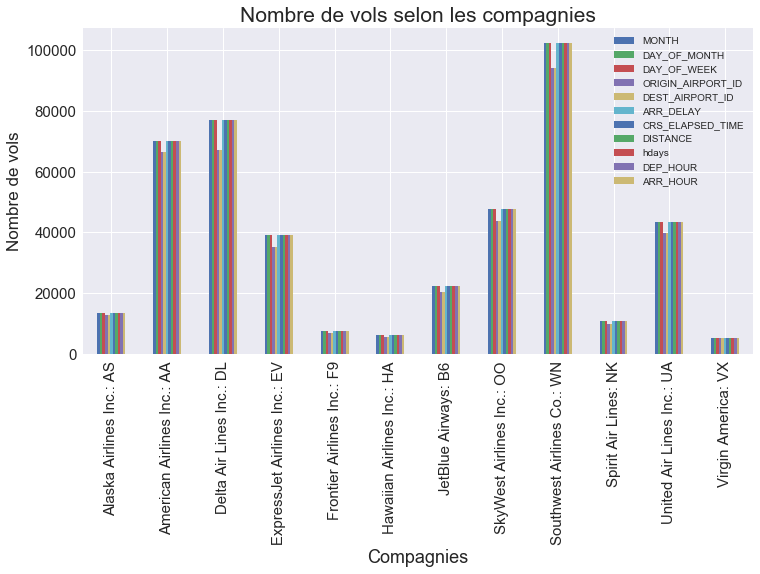

In [169]:
# Barplot avec le nombre de vol par compagnie
# Récupération de la liste du Top20 compagnie
Ix20 = data2['AIRLINE_ID'].value_counts()[0:20].index
Ix20.tolist()
print(Ix20)

# Création du dataframe filtré sur ces pays
df2 = data2[data2['AIRLINE_ID'].isin(Ix20)]
df2.groupby(['AIRLINE_ID']).count().plot(
    kind='bar', figsize=(12, 6), fontsize=15)
plt.title('Nombre de vols selon les compagnies', fontsize=21)
plt.xlabel('Compagnies', fontsize=18)
plt.ylabel('Nombre de vols', fontsize=17)
plt.show()

Index(['Southwest Airlines Co.: WN', 'Delta Air Lines Inc.: DL',
       'American Airlines Inc.: AA', 'SkyWest Airlines Inc.: OO',
       'United Air Lines Inc.: UA', 'ExpressJet Airlines Inc.: EV',
       'JetBlue Airways: B6', 'Alaska Airlines Inc.: AS',
       'Spirit Air Lines: NK', 'Frontier Airlines Inc.: F9',
       'Hawaiian Airlines Inc.: HA', 'Virgin America: VX'],
      dtype='object')


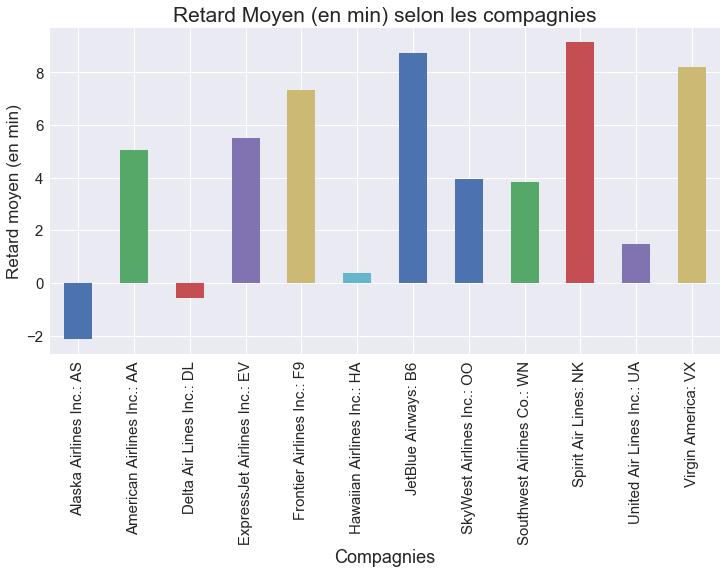

In [170]:
# Barplot avec le nombre de vol par compagnie
# Récupération de la liste du Top20 compagnie
Ix20 = data2['AIRLINE_ID'].value_counts()[0:20].index
Ix20.tolist()
print(Ix20)

# Création du dataframe filtré sur ces pays
df2 = data2[data2['AIRLINE_ID'].isin(Ix20)]
df2.groupby(['AIRLINE_ID'])['ARR_DELAY'].mean().plot(
    kind='bar', figsize=(12, 6), fontsize=15)
plt.title('Retard Moyen (en min) selon les compagnies', fontsize=21)
plt.xlabel('Compagnies', fontsize=18)
plt.ylabel('Retard moyen (en min)', fontsize=17)
plt.show()

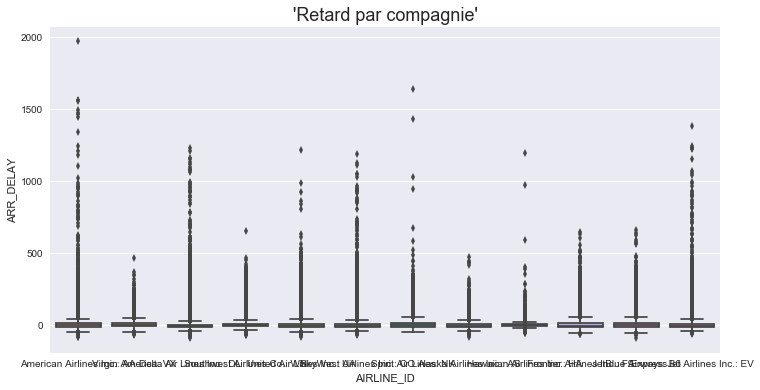

In [171]:
fig = plt.figure(figsize=(12, 6))
sns.boxplot(x=data2['AIRLINE_ID'], y = data2['ARR_DELAY'])
plt.title("'Retard par compagnie'", fontsize = 18)
plt.show()

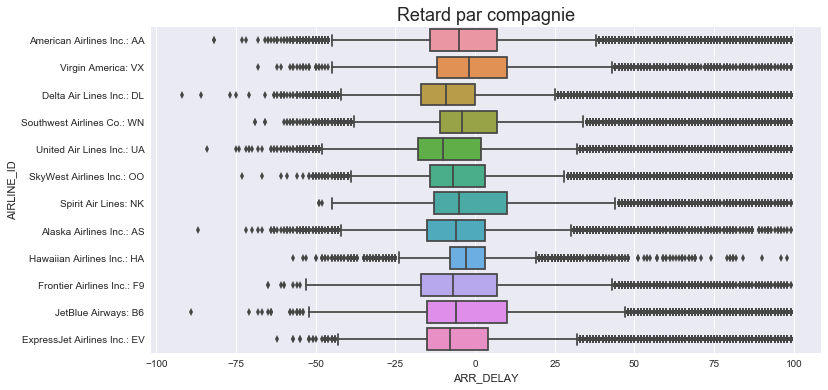

In [172]:
fig = plt.figure(figsize=(12, 6))
sns.boxplot(y=data2['AIRLINE_ID'], x = data2[data2['ARR_DELAY']<100]['ARR_DELAY'])
plt.title("Retard par compagnie", fontsize = 18)
plt.show()

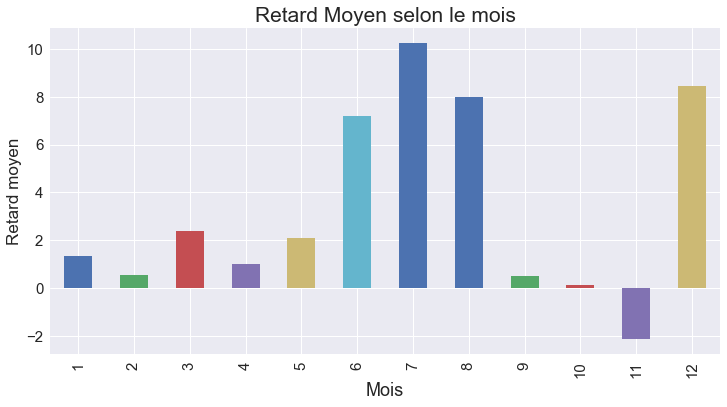

In [173]:
# Barplot avec le retard moyen par mois 
data2.groupby(['MONTH'])['ARR_DELAY'].mean().plot(
    kind='bar', figsize=(12, 6), fontsize=15)
plt.title('Retard Moyen selon le mois', fontsize=21)
plt.xlabel('Mois', fontsize=18)
plt.ylabel('Retard moyen', fontsize=17)
plt.show()

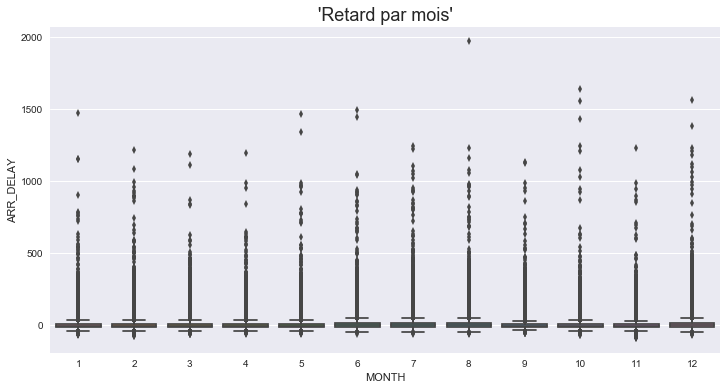

In [174]:
fig = plt.figure(figsize=(12, 6))
sns.boxplot(x=data2['MONTH'], y = data2['ARR_DELAY'])
plt.title("'Retard par mois'", fontsize = 18)
plt.show()

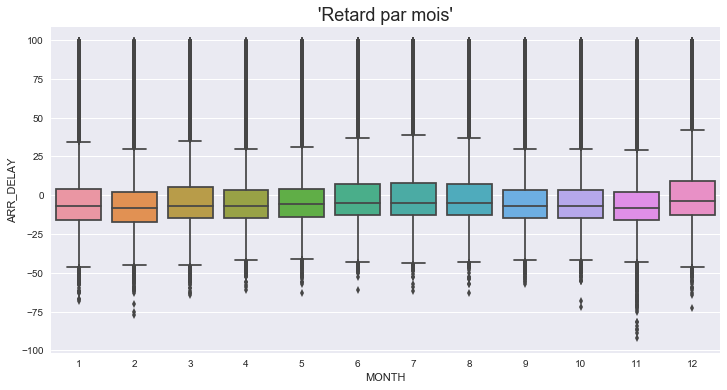

In [175]:
fig = plt.figure(figsize=(12, 6))
sns.boxplot(x=data2['MONTH'], y = data2[data2['ARR_DELAY']<100]['ARR_DELAY'])
plt.title("'Retard par mois'", fontsize = 18)
plt.show()

Index(['Atlanta, GA: Hartsfield-Jackson Atlanta International',
       'Chicago, IL: Chicago O'Hare International',
       'Denver, CO: Denver International',
       'Los Angeles, CA: Los Angeles International',
       'Dallas/Fort Worth, TX: Dallas/Fort Worth International',
       'San Francisco, CA: San Francisco International',
       'Phoenix, AZ: Phoenix Sky Harbor International',
       'Las Vegas, NV: McCarran International',
       'Houston, TX: George Bush Intercontinental/Houston',
       'Seattle, WA: Seattle/Tacoma International'],
      dtype='object')


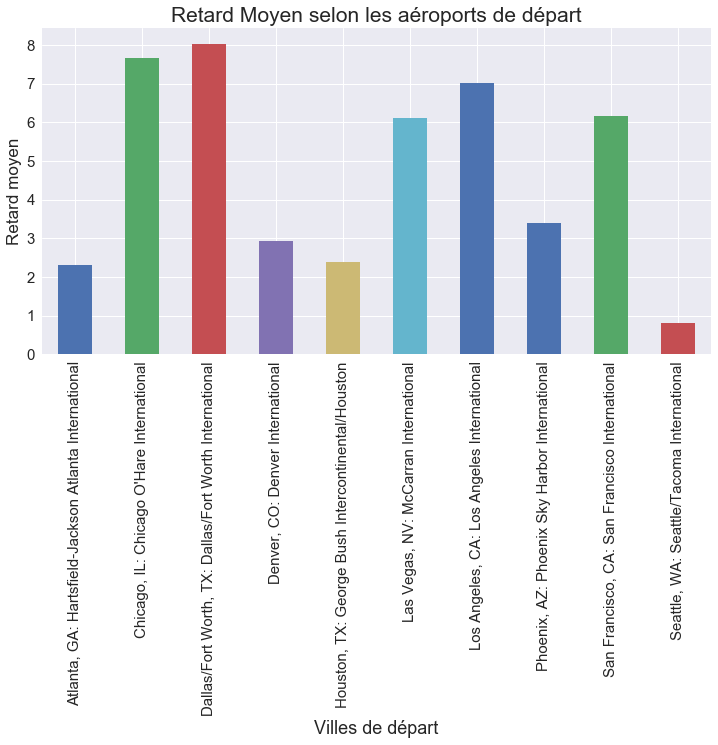

In [176]:
# Analyse sur les villes, top 10 des villes les plus desservies 
Ix10 = data2['ORIGIN_AIRPORT_ID'].value_counts()[0:10].index
Ix10.tolist()
print(Ix10)

# Création du dataframe filtré sur ces villes
df4 = data2[data2['ORIGIN_AIRPORT_ID'].isin(Ix10)]
df4.groupby(['ORIGIN_AIRPORT_ID'])['ARR_DELAY'].mean().plot(
    kind='bar', figsize=(12, 6), fontsize=15)
plt.title('Retard Moyen selon les aéroports de départ', fontsize=21)
plt.xlabel('Villes de départ', fontsize=18)
plt.ylabel('Retard moyen', fontsize=17)
plt.show()

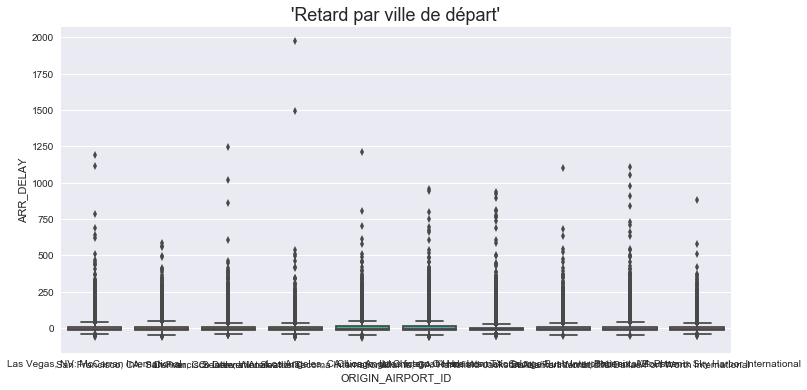

In [177]:
fig = plt.figure(figsize=(12, 6))
sns.boxplot(x=df4['ORIGIN_AIRPORT_ID'], y = df4['ARR_DELAY'])
plt.title("'Retard par ville de départ'", fontsize = 18)
plt.show()

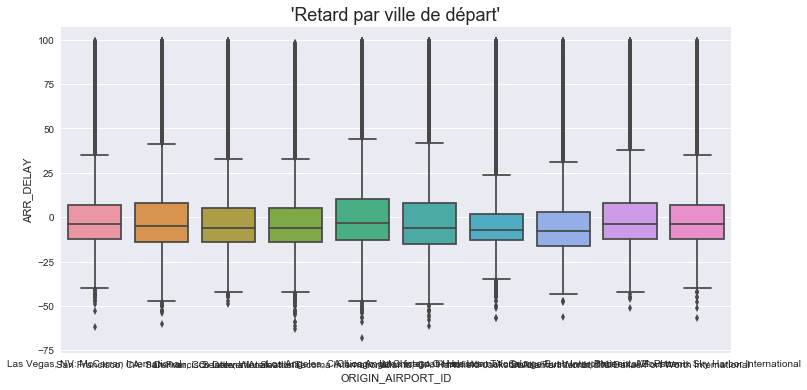

In [178]:
fig = plt.figure(figsize=(12, 6))
sns.boxplot(x=df4['ORIGIN_AIRPORT_ID'], y = df4[df4['ARR_DELAY']<100]['ARR_DELAY'])
plt.title("'Retard par ville de départ'", fontsize = 18)
plt.show()

Index(['Atlanta, GA: Hartsfield-Jackson Atlanta International',
       'Chicago, IL: Chicago O'Hare International',
       'Denver, CO: Denver International',
       'Los Angeles, CA: Los Angeles International',
       'Dallas/Fort Worth, TX: Dallas/Fort Worth International',
       'San Francisco, CA: San Francisco International',
       'Phoenix, AZ: Phoenix Sky Harbor International',
       'Las Vegas, NV: McCarran International',
       'Houston, TX: George Bush Intercontinental/Houston',
       'Seattle, WA: Seattle/Tacoma International'],
      dtype='object')


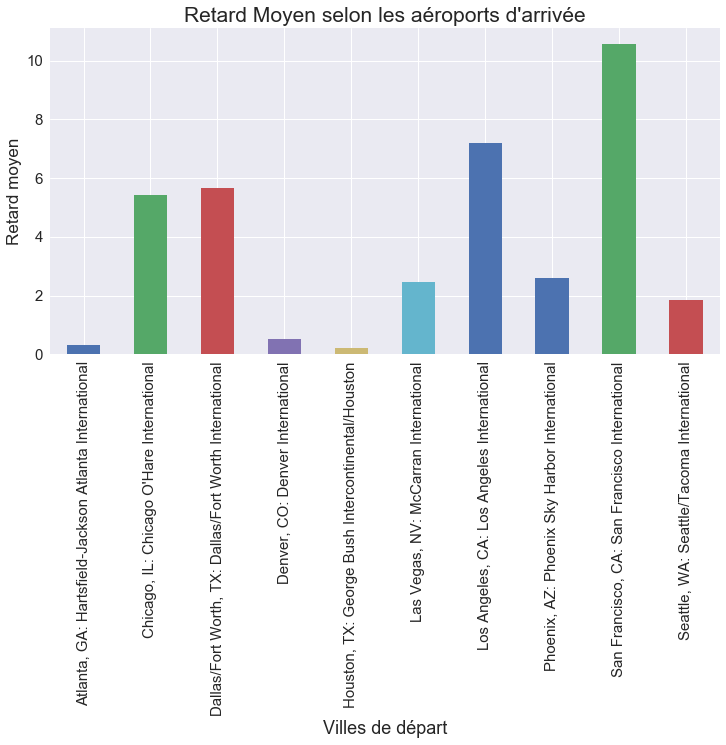

In [179]:
# Analyse sur les villes, top 10 des villes les plus desservies 
Ix10 = data2['DEST_AIRPORT_ID'].value_counts()[0:10].index
Ix10.tolist()
print(Ix10)

# Création du dataframe filtré sur ces aéroports
df4 = data2[data2['DEST_AIRPORT_ID'].isin(Ix10)]
df4.groupby(['DEST_AIRPORT_ID'])['ARR_DELAY'].mean().plot(
    kind='bar', figsize=(12, 6), fontsize=15)
plt.title("Retard Moyen selon les aéroports d'arrivée", fontsize=21)
plt.xlabel('Villes de départ', fontsize=18)
plt.ylabel('Retard moyen', fontsize=17)
plt.show()

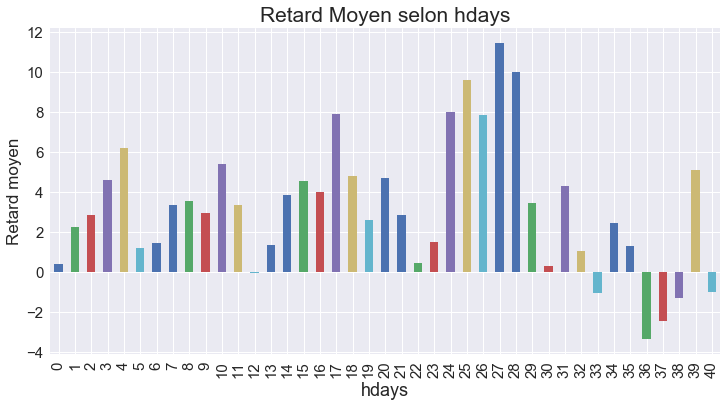

In [180]:
data2.groupby(['hdays'])['ARR_DELAY'].mean().plot(
    kind='bar', figsize=(12, 6), fontsize=15)
plt.title('Retard Moyen selon hdays', fontsize=21)
plt.xlabel('hdays', fontsize=18)
plt.ylabel('Retard moyen', fontsize=17)
plt.show()

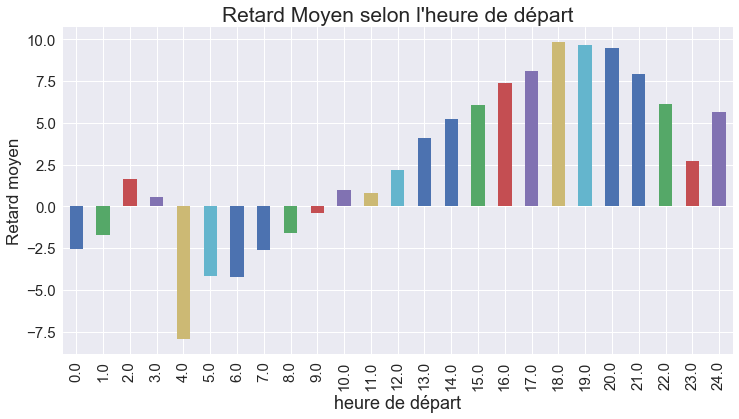

In [181]:
data2.groupby(['DEP_HOUR'])['ARR_DELAY'].mean().plot(
    kind='bar', figsize=(12, 6), fontsize=15)
plt.title("Retard Moyen selon l'heure de départ", fontsize=21)
plt.xlabel('heure de départ', fontsize=18)
plt.ylabel('Retard moyen', fontsize=17)
plt.show()

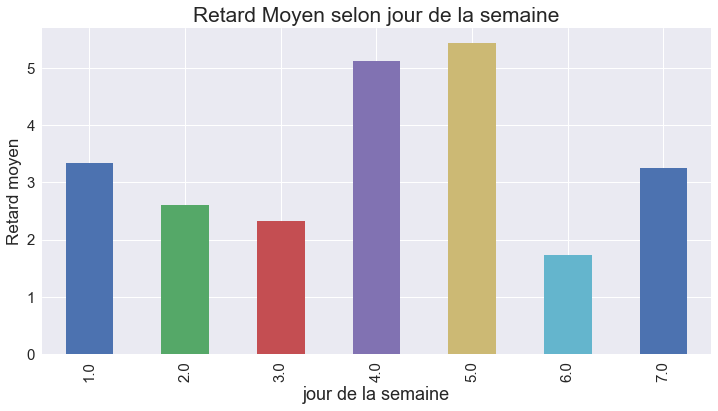

In [182]:
data2.groupby(['DAY_OF_WEEK'])['ARR_DELAY'].mean().plot(
    kind='bar', figsize=(12, 6), fontsize=15)
plt.title("Retard Moyen selon jour de la semaine", fontsize=21)
plt.xlabel('jour de la semaine', fontsize=18)
plt.ylabel('Retard moyen', fontsize=17)
plt.show()

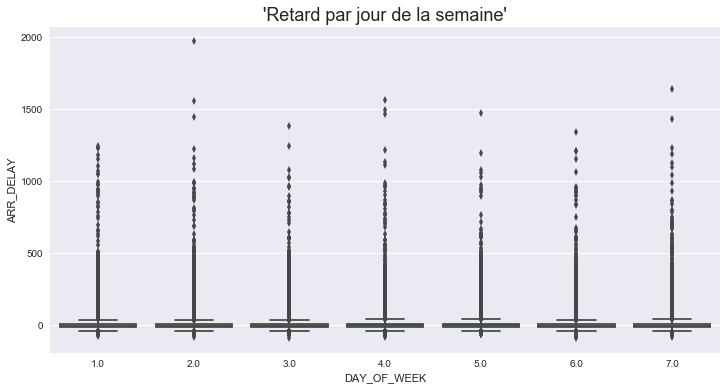

In [183]:
fig = plt.figure(figsize=(12, 6))
sns.boxplot(x=data2['DAY_OF_WEEK'], y = data2['ARR_DELAY'])
plt.title("'Retard par jour de la semaine'", fontsize = 18)
plt.show()

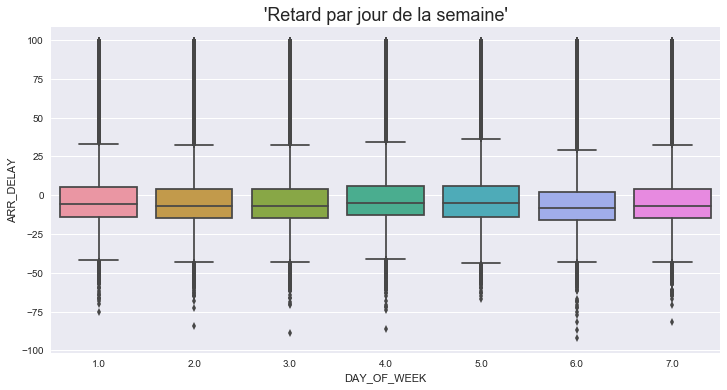

In [184]:
fig = plt.figure(figsize=(12, 6))
sns.boxplot(x=data2['DAY_OF_WEEK'], y = data2[data2['ARR_DELAY']<100]['ARR_DELAY'])
plt.title("'Retard par jour de la semaine'", fontsize = 18)
plt.show()

Il y a trop de villes différentes dans notre dataframe, nous décidons de ne pas considérer les variables d'aéroport de départ et d'arrivée dans un prmeier temps

In [185]:
data2['ORIGIN_AIRPORT_ID'].nunique()

308

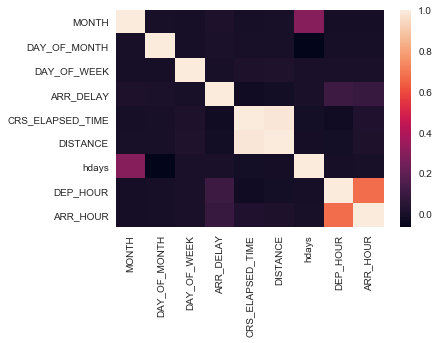

In [186]:
sns.heatmap(data2.corr())

On enlève les lignes où le retard est trop important car nous avons trop peu de données sur ces retards "exceptionnels" (Top 5%)

In [187]:
data2 = data2[data2['ARR_DELAY'] < np.percentile(data2['ARR_DELAY'], 95)]

In [188]:
data2 = data2.drop(['ARR_HOUR', 'CRS_ELAPSED_TIME'], axis=1)

In [189]:
data3 = data2

In [190]:
data4 = data2

In [191]:
data5 = data2

Il y a beaucoup d'aéroports présents dans notre base de données, cela représentera beaucoup de variables et alourdira notre modèle  '

In [192]:
data2 = data2.drop(['ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID'], axis=1)

# Export de la base de donnée traitée 

In [193]:
data2.head()

MONTH  DAY_OF_MONTH  DAY_OF_WEEK                  AIRLINE_ID  \
2257351      5          23.0          1.0  American Airlines Inc.: AA   
5530416     12          19.0          1.0          Virgin America: VX   
693573       2          18.0          4.0    Delta Air Lines Inc.: DL   
4108819      9          21.0          3.0  Southwest Airlines Co.: WN   
3667434      8           4.0          4.0   United Air Lines Inc.: UA   

         ARR_DELAY  DISTANCE  hdays  DEP_HOUR  
2257351      -13.0     936.0      7      22.0  
5530416       13.0    2586.0      6      12.0  
693573       -22.0     332.0      3      16.0  
4108819      -10.0     407.0     16      18.0  
3667434       -9.0     337.0     31       9.0

In [194]:
data2.to_csv(path_or_buf = 'C:/Users/flemeill/Documents/01 - Projets OC/04 - Projet 4 - Retards/Main project/data.csv')

# Création d'autres jeu de données 

## Suite du Feature Engineering 

Nous allons utiliser ici le jeu de données en ayant garder les variables d'aéroport de départ et d'arrivée
pour pouvoir comparer les résultats et observer si cette information améliore nos modèles

In [195]:
data3.to_csv(path_or_buf = 'C:/Users/flemeill/Documents/01 - Projets OC/04 - Projet 4 - Retards/Main project/data_city.csv')

### Division d'une journée en 3 : Matin - Après-midi - Soirée

L'idée est ici est de ne plus considérer les heures de départ et d'arrivée mais la catégorie de la journée auquels appartiennent 
ces événements : Matin - Midi - Soirée (0-8, 8-16, 16-24)

In [196]:
data4 = data4.drop(['ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID'], axis=1)

Création du dictionnaire Heure - Matin/midi/soir

In [197]:
dict_day = {'0.0': 'Early', '1.0': 'Early', '2.0': 'Early', '3.0': 'Early', '4.0': 'Early', '5.0': 'Early', '6.0': 'Early', '7.0': 'Early', '8.0': 'Early',
            '9.0': 'Mid', '10.0': 'Mid', '11.0': 'Mid', '12.0': 'Mid', '13.0': 'Mid', '14.0': 'Mid', '15.0': 'Mid', '16.0': 'Mid',
            '17.0': 'late', '18.0': 'late', '19.0': 'late', '20.0': 'late', '21.0': 'late', '22.0': 'late', '23.0': 'late', '24.0': 'late'}

In [198]:
data4['DEP_HOUR'] = data4['DEP_HOUR'].astype(str)

In [199]:
data4['EML'] = data4['DEP_HOUR'].map(dict_day)

In [200]:
data4['EML'].head()

2257351    late
5530416     Mid
693573      Mid
4108819    late
3667434     Mid
Name: EML, dtype: object

In [201]:
data4.to_csv(path_or_buf = 'C:/Users/flemeill/Documents/01 - Projets OC/04 - Projet 4 - Retards/Main project/data_eml.csv')

### Création d'une table avec les données méteo

Nous avons récupéré les moyennes mensuelles météorologiques aux Etats-Unis pour 3 indicateurs pouvant influer 
sur la circulation des avions : Les précipitations, le vent, et l'ensoillement (taux de présence de nuages)

In [202]:
Mois = [1,2,3,4,5,6,7,8,9,10,11,12]
Precipitations =[3,3,3,3,3,3,3,4,3,2,2,3]
Vent = [18,20,21,21,19,19,18,17,17,18,17,18]
nuage = [60,54,56,48,50,39,38,41,40,42,45,61]

In [203]:
Meteo = pd.DataFrame([Precipitations, Vent, nuage], index=('P','V','N'), columns=Mois, dtype=int)

In [204]:
Meteo.head()

1   2   3   4   5   6   7   8   9   10  11  12
P   3   3   3   3   3   3   3   4   3   2   2   3
V  18  20  21  21  19  19  18  17  17  18  17  18
N  60  54  56  48  50  39  38  41  40  42  45  61

In [205]:
dict_P = dict(zip(Mois, Precipitations))
dict_V = dict(zip(Mois, Vent))
dict_N = dict(zip(Mois, nuage))

In [206]:
data5['Prec'] = data5['MONTH'].map(dict_P)
data5['Vent'] = data5['MONTH'].map(dict_V)
data5['Nuage'] = data5['MONTH'].map(dict_N)
data5['EML'] = data4['EML']

#### Création d'une variable weekend

In [207]:
dict_WE = dict(zip([1,2,3,4,5,6,7], [0,0,0,0,0,1,1]))
data5['WE'] = data5['DAY_OF_WEEK'].map(dict_WE)

In [208]:
data5['WE'].head(10)

2257351    0
5530416    0
693573     0
4108819    0
3667434    0
3088719    0
124746     0
5429974    0
4956944    0
5068183    1
Name: WE, dtype: int64

In [209]:
data5 = data5.drop(['ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID'], axis=1)

In [210]:
data5.head()

MONTH  DAY_OF_MONTH  DAY_OF_WEEK                  AIRLINE_ID  \
2257351      5          23.0          1.0  American Airlines Inc.: AA   
5530416     12          19.0          1.0          Virgin America: VX   
693573       2          18.0          4.0    Delta Air Lines Inc.: DL   
4108819      9          21.0          3.0  Southwest Airlines Co.: WN   
3667434      8           4.0          4.0   United Air Lines Inc.: UA   

         ARR_DELAY  DISTANCE  hdays  DEP_HOUR  Prec  Vent  Nuage   EML  WE  
2257351      -13.0     936.0      7      22.0     3    19     50  late   0  
5530416       13.0    2586.0      6      12.0     3    18     61   Mid   0  
693573       -22.0     332.0      3      16.0     3    20     54   Mid   0  
4108819      -10.0     407.0     16      18.0     3    17     40  late   0  
3667434       -9.0     337.0     31       9.0     4    17     41   Mid   0

In [211]:
data5.to_csv(path_or_buf = 'C:/Users/flemeill/Documents/01 - Projets OC/04 - Projet 4 - Retards/Main project/data_meteo.csv')

### Export des dictionnaires 

In [212]:
import pickle 
with open('dict_V.pkl', 'wb') as fid:
    pickle.dump(dict_V, fid,2)        
with open('dict_P.pkl', 'wb') as fid:
    pickle.dump(dict_P, fid,2)
with open('dict_N.pkl', 'wb') as fid:
    pickle.dump(dict_N, fid,2)
with open('dict_WE.pkl', 'wb') as fid:
    pickle.dump(dict_WE, fid,2)
with open('dict_hdays.pkl', 'wb') as fid:
    pickle.dump(dict_hdays, fid,2)
with open('dict_EML.pkl', 'wb') as fid:
    pickle.dump(dict_day, fid,2)

In [213]:
dict_WE

{1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 1}

In [214]:
dict_P

{1: 3, 2: 3, 3: 3, 4: 3, 5: 3, 6: 3, 7: 3, 8: 4, 9: 3, 10: 2, 11: 2, 12: 3}